In [118]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

This notebook contains a summary of all the work Sam Deverett did for Dieta.

# Problem Statement

## General

An estimated 25-45 million Americans suffer from irritable bowel syndrome (IBS). While a professional is able to diagnose patients with the intestinal disorder, the best current cure is to simply try a plethora of diets until finding one that alleviates the symptom. This takes tremendous effort and lots of time - without even guarenteeing a solution.

Dieta is a mobile and web applitcation that uses data science to accelerate the healing process for IBS patients. By analyzing data on a user's digestive health, including their food intake and bowel movements, Dieta is able to more effectively identify triggers and more personally recommend diets. Furthermore, by anonymously aggregating insights from many users, Dieta allows patients with similar symptoms to grow better both faster and more unified.

## Project Specific

This project focuses on finding insights across users. The goal is to be able to suggest users strategies to combat their symptoms based on the insights learned from patients just like them. For example, if it is known that a user belongs to a group of IBS patients with a certain subset of symtpoms and there is another patient in that group who has found a diet that works to alleviate those symptoms, Dieta would identify this and then suggest that diet to the original user. 

I will frame this problem as a clustering one. Clustering, a type of unsupervised machine learning, will allow me to detect groups of users. (This project will not include the recommender engine applied to the clustering insights.)

Performing clustering will involve the following steps:

* [setting up](#set_up) the environment
* [loading](#loading) the data
* [exploring](#EDA) the data
* [preprocessing](#preprocessing) the data
* [feature engineering](#feature_engineering) distinguishing characteristics of users
* selecting the [number of clusters](#num_clusters)
* running various [clustering](#clustering) algorithms
* [choosing](#choose) the best clustering

Although there is no "correct" way to cluster data, the merit of each clustering will be determined (roughly) by comparing the outputted clusters to medical research's best current model, namely subdiagnoses of IBS.
(### Would be great to have had the actual labels of the patients; then I could've had a true baseline clustering to "beat")

<a id='set_up'></a>

# Set Up

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<a id='loading'></a>

# Loading the Data

The data are collected from the Dieta mobile application. Users can input their foods, drinks, medications, symtpoms, bowel movements, exercise, sleep, and mood. 

<img src='inputs.png' style="width:200px;height:300px"></img>

In this project, I will only use data related to patients' symptoms and bowel movements. Thus, the clusters formed will only be functions of patients' symptoms and bowel movements. This means that a patient's personal details, like their triggers and medications, will *not* inform the clustering whatsoever. (### I would have liked to use data about users' triggers, but I was not given access to this data ###)

The data for **bowel movements** look as follows:

In [29]:
bm_df = pd.read_csv('bms.csv', index_col='id')
bm_df.head()

,consistency,difficulty,pain,smell,completeness,urgency,duration,occurred_at,fake_user_id
id,,,,,,,,,
6162,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 19:10:00,480
6161,40.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-04 11:30:00,480
6131,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-03 14:05:00,480
6103,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 22:00:00,480
6102,50.0,NaN,NaN,NaN,NaN,NaN,0,2019-10-02 14:00:00,480


In [115]:
print(f'There are {bm_df.shape[0]} rows and {bm_df.shape[1]} columns.')

hide_toggle()

There are 6015 rows and 9 columns.


The data for **symptoms** look as follows:

In [31]:
sym_df = pd.read_csv('syms.csv')
sym_df.head()

,occurred_at,symptom,intensity,duration,fake_user_id
0,2019-06-20 22:00:00,stomach pain,25,60,480
1,2019-06-20 22:00:00,urgency,40,60,480
2,2019-06-25 18:00:00,pain,15,0,480
3,2019-06-20 16:00:00,urgency,5,0,480
4,2019-06-20 12:00:00,urgency,40,0,480


In [32]:
print(f'There are {bm_df.shape[0]} rows and {bm_df.shape[1]} columns.')

There are 6015 rows and 9 columns.


<a id='EDA'></a>

# EDA

### Missing Values

In [33]:
print('Bowel Movements:')
display(bm_df.isnull().sum() / len(bm_df) * 100)

print('Symptoms:')
display(sym_df.isnull().sum() / len(sym_df) * 100)

Bowel Movements:


consistency      1.213633
difficulty      49.609310
pain            70.656692
smell           66.932668
completeness    41.463009
urgency         55.627598
duration         0.000000
occurred_at      0.000000
fake_user_id     0.000000
dtype: float64

Symptoms:


occurred_at     0.0
symptom         0.0
intensity       0.0
duration        0.0
fake_user_id    0.0
dtype: float64

These percents are slightly misleading, because the attribute "duration" has a preset value of 0. Here is a more accurate metric of missing "duration" values:

In [83]:
print('Bowel Movements:')
display(len(bm_df[bm_df['duration'] == 0]) / len(bm_df))

print('Symptoms:')
display(len(sym_df[sym_df['duration'] == 0]) / len(sym_df))

Bowel Movements:


0.8513715710723192

Symptoms:


0.7907623017584208

Where do these missing values come from? How are they distributed among users?

In [87]:
def get_user_null_values(df):
    user_null_values = {}
    for user_id in df['fake_user_id'].unique():
        user_df = df[df['fake_user_id'] == user_id]
        null_proportions = user_df.isnull().sum() / len(user_df)
        user_null_values[user_id] = null_proportions
    return user_null_values

def proportion_of_null_per_user(df, feature):
    null_proportions = {}
    user_null_values = get_user_null_values(df)
    for key in user_null_values:
        null_proportion = user_null_values[key][feature]
        null_proportions[key] = null_proportion
    return null_proportions

def plot_null_proportions_per_user(df, feature):
    dic = proportion_of_null_per_user(df, feature)
    ids = [str(i) for i in dic.keys()]
    proportions = list(dic.values())
    mean, median = np.mean(proportions), np.median(proportions)
    plt.figure(figsize=(20,10))
    plt.hist(proportions, range=[0, 1])
    plt.vlines(mean, 0, 100, 'red', 'dashed', 'mean')
    plt.vlines(median, 0, 100, 'green', 'dashed', 'median')
    plt.legend()
    plt.title(f'proportion of null {feature} values per user');

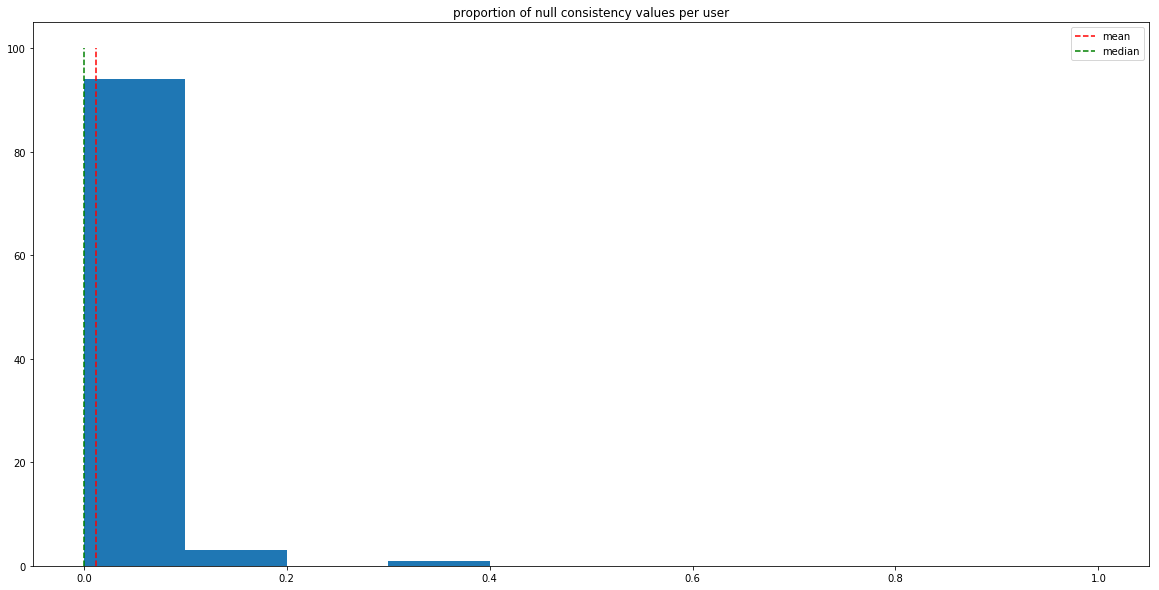

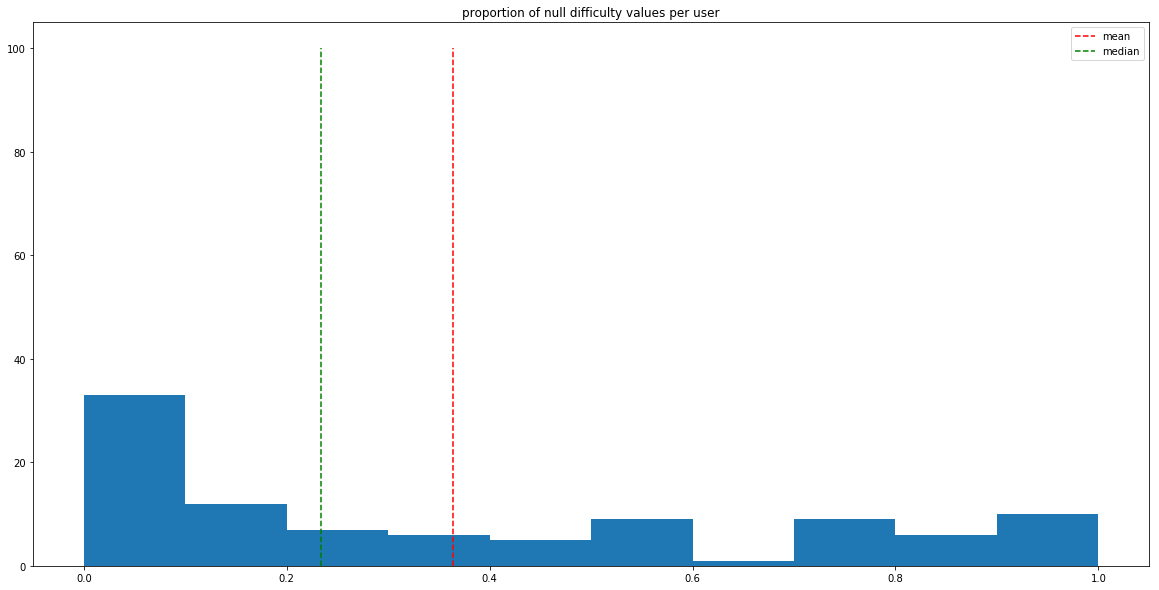

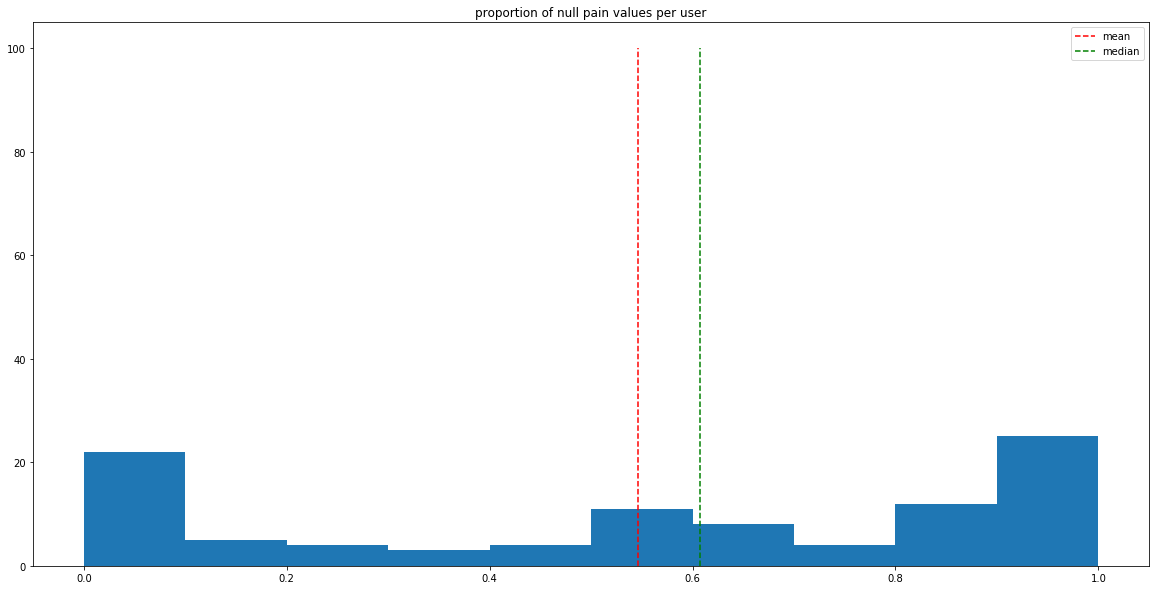

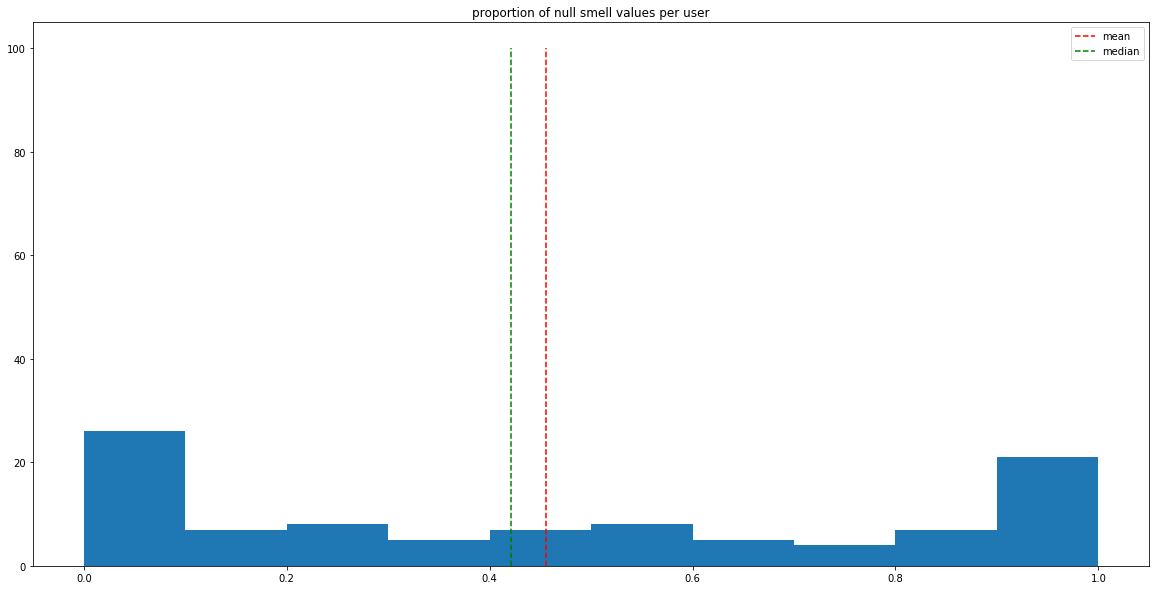

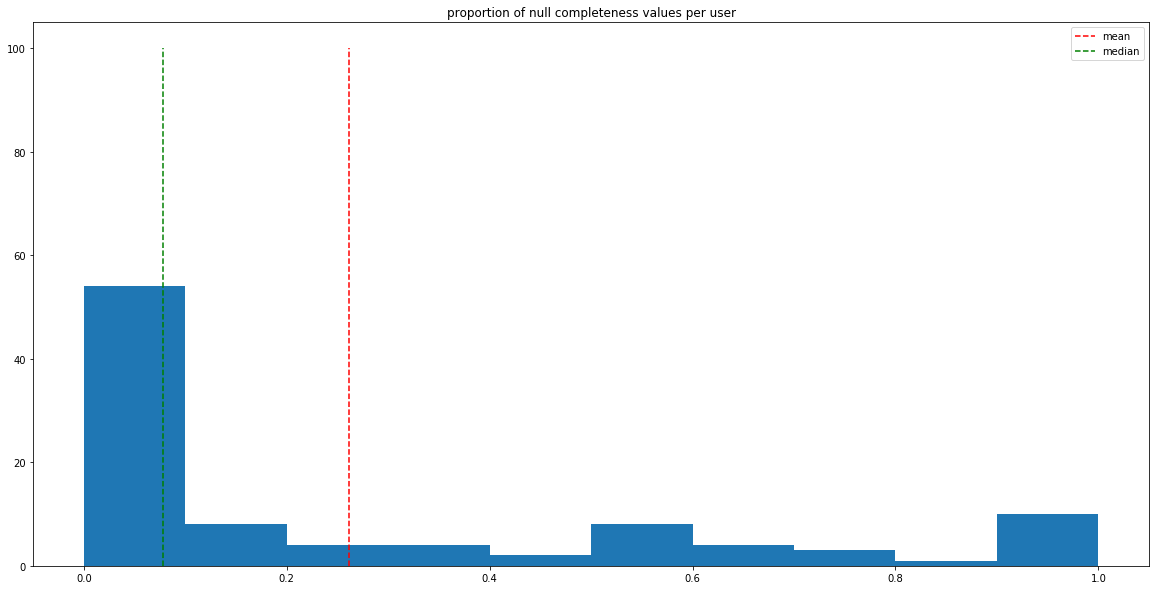

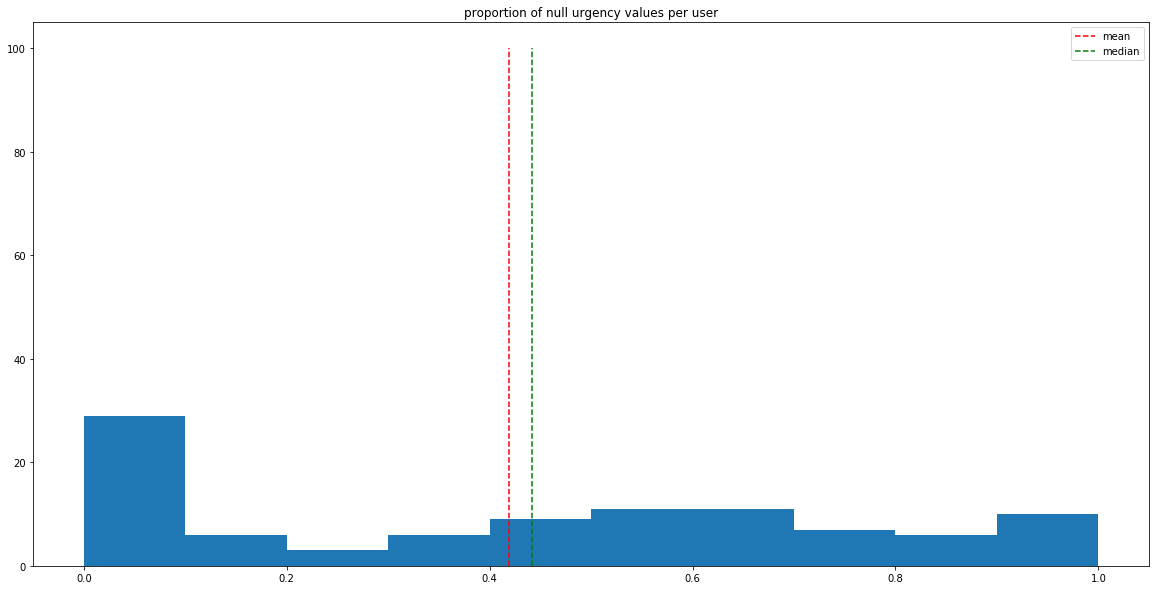

In [88]:
print('Bowel Movements:')
bm_features = ['consistency', 'difficulty', 'pain', 'smell', 'completeness', 'urgency']
for feature in bm_features:
    plot_null_proportions_per_user(bm_df, feature)

### Imputation

As shown above, many attributes have a significant percent of missing values. I considered two options for dealing with this:

**1)** Dropping data points with missing values.

**2)** Imputing values for attributes based on that attribute's values in other data points from the *same* user. (I did *not* consider imputing values based on data points from all other users, because this would make each user more similar, making clustering both harder and less effective.)

**REVISIT**
I decided to not impute (too large a percent of null values to be statistically sound; negligable effect)

### Attribute Distributions

In [102]:
def plot_feature_distribution(df, feature):
    plt.figure(figsize=(20,10))
    plt.hist(list(bm_df[feature]), range=[0, 100])
    plt.title(f'{feature} distribution');

Bowel Movements:


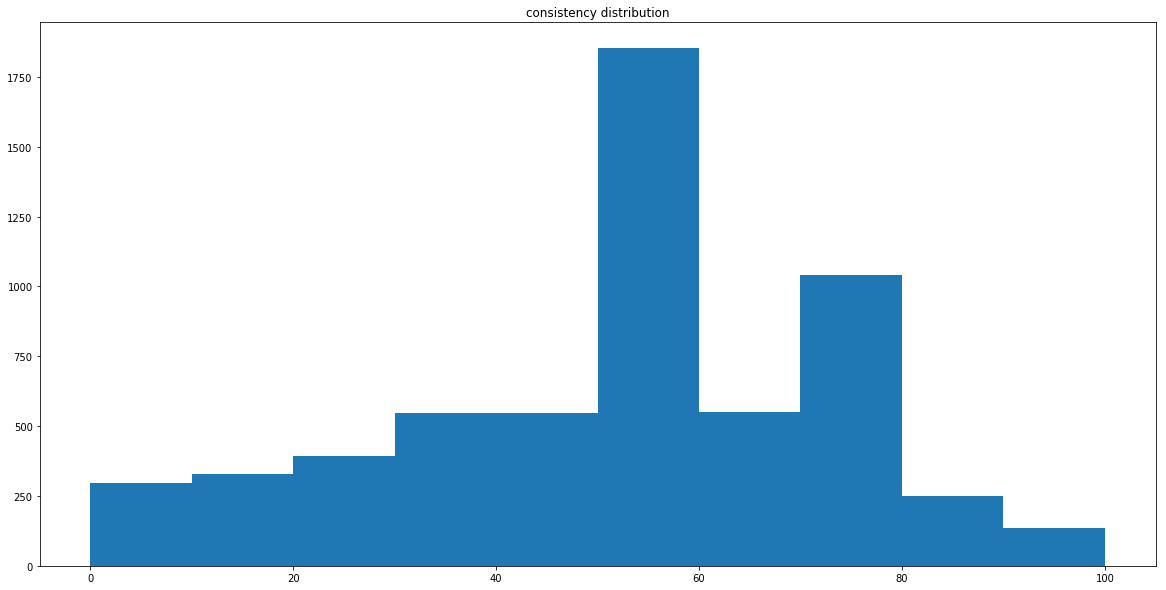

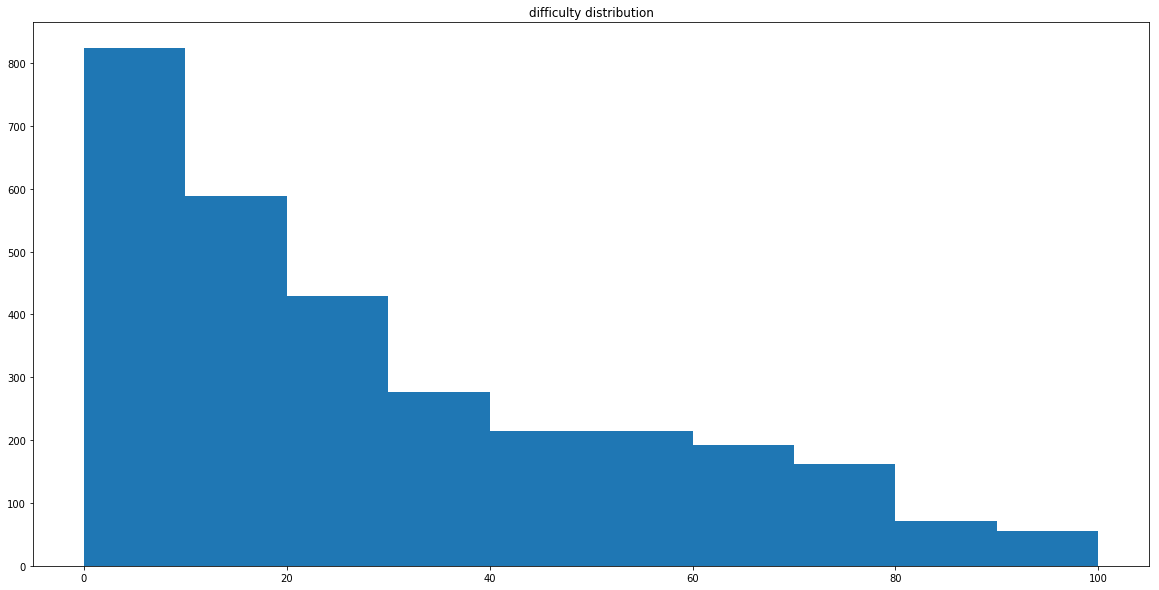

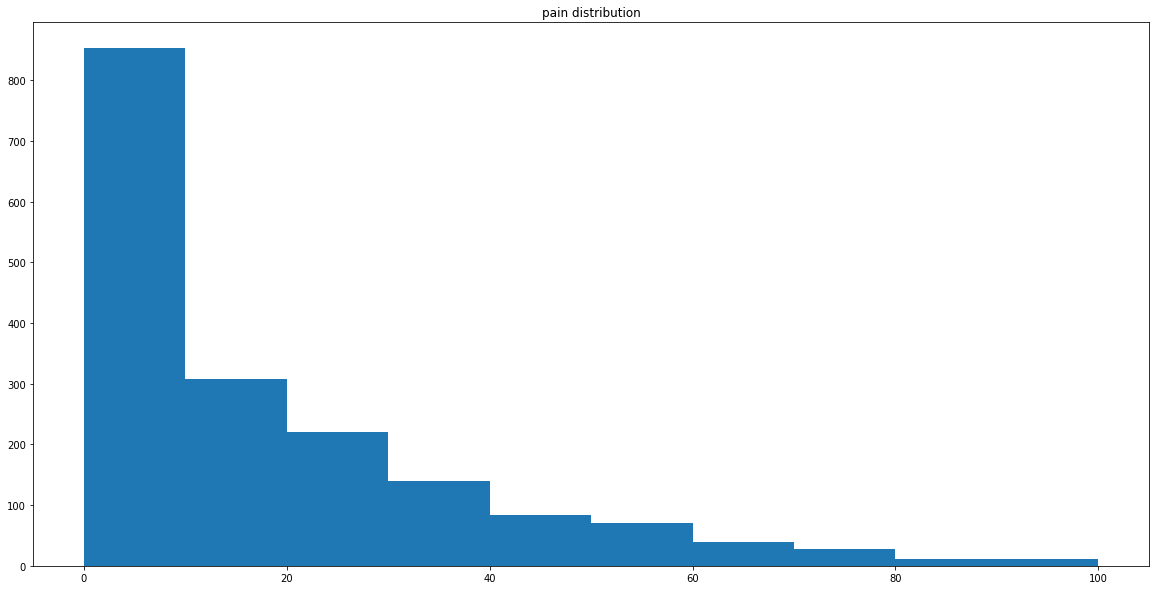

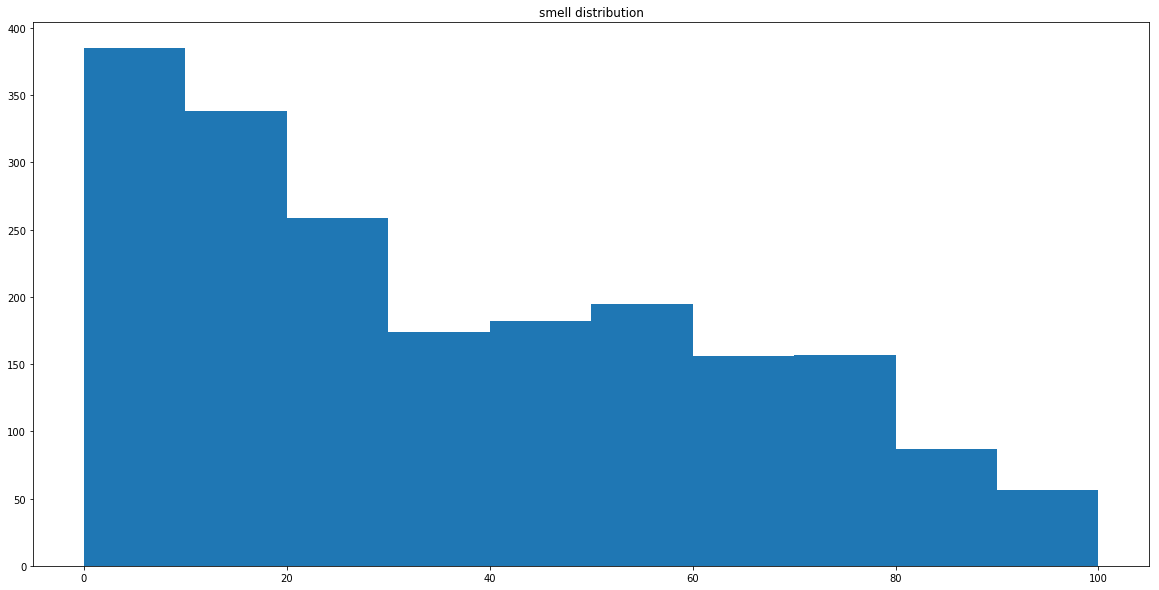

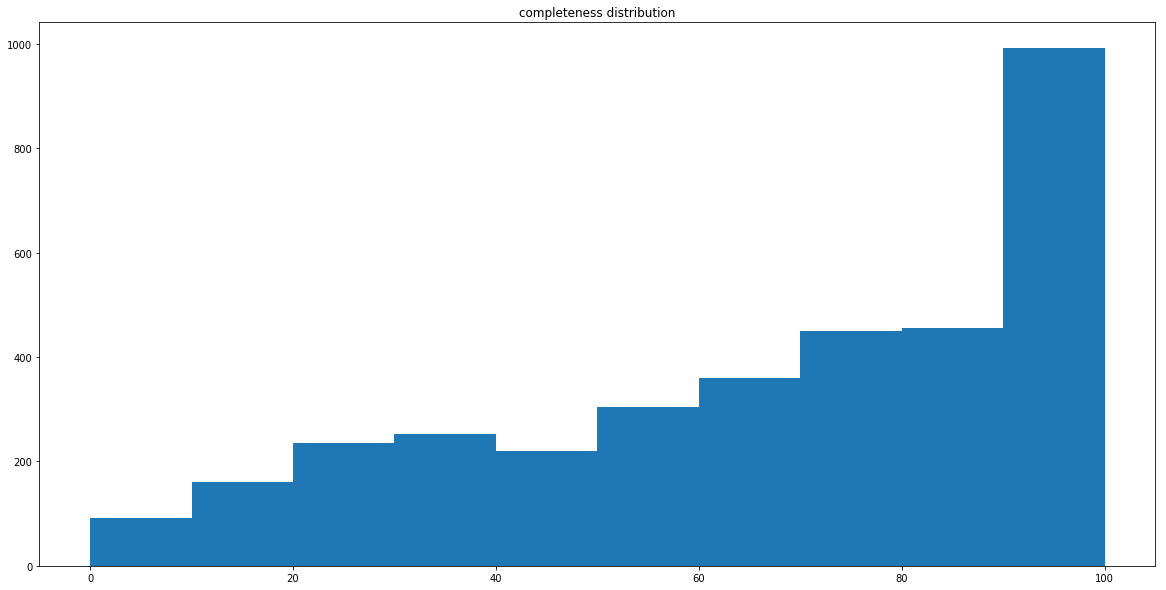

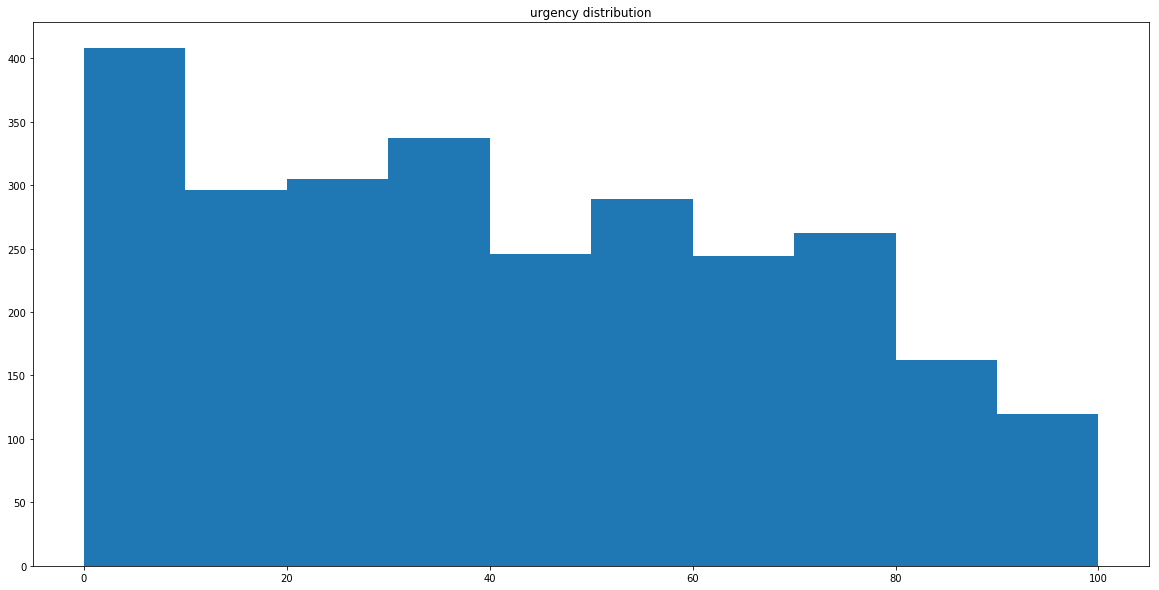

In [113]:
print('Bowel Movements:')
bm_features = ['consistency', 'difficulty', 'pain', 'smell', 'completeness', 'urgency']
for feature in bm_features:
    plot_feature_distribution(bm_df, feature)

#### Intensity

(Analyze distribution - lots of strings)

#### Occured At

#### Duration

<a id='preprocessing'></a>

# Preprocessing

<a id='feature_engineering'></a>

# Feature Engineering

<a id='num_clusters'></a>

# Selecting Number of Clusters

<a id='clustering'></a>

# Clustering

<a id='choose'></a>

# Choosing Best Clustering